## 신경망에서 기울기

In [1]:
import sys, os
import numpy as np
import matplotlib.pylab as plt

In [2]:
def softmax(matrix):
    maximum_of_matrix = np.max(matrix)
    difference_from_maximum = matrix - maximum_of_matrix
    exponential_of_difference = np.exp(difference_from_maximum)
    sum_of_exponential = np.sum(exponential_of_difference)
    y = exponential_of_difference / sum_of_exponential
    
    return y

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

def numerical_gradient(f, x):
    h= 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) +h
        fxh1 = f(x) #f(x+h)
        
        x[idx] = tmp_val - h
        fxh2 = f(x) #f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()
        
    return grad

In [3]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [4]:
net = simpleNet()
print(net.W)

[[ 0.25651706 -1.59162397 -1.33365074]
 [-0.84044931 -0.43253016 -1.13902786]]


In [5]:
x=np.array([0.6, 0.9])
p=net.predict(x)
print(p)

[-0.60249414 -1.34425152 -1.82531552]


In [6]:
np.argmax(p) #몇번째 가장 높은 값이 있는지?
#n번째다...

0

In [7]:
t=np.array([0, 0, 1])#임의로 2라는 숫자로 가정하면
net.loss(x, t)#loss값 계산해보기

1.7941813582397959

In [8]:
def f(W):
    return net.loss(x, t)

In [9]:
dw = numerical_gradient(f, net.W)
print(dw)

[[ 0.33885371  0.16138795 -0.50024165]
 [ 0.50828056  0.24208192 -0.75036248]]


In [10]:
f = lambda w: net.loss(x, t)
dw = numerical_gradient(f, net.W)
print(dw)

[[ 0.33885371  0.16138795 -0.50024165]
 [ 0.50828056  0.24208192 -0.75036248]]


## 신경망 구현하기
- 밑바닥부터 시작하는 딥러닝
- 데이터 분석(), 인공지능 2020 포트폴리오..

In [11]:
import sys, os
sys.path.append("./dataset")
import numpy as np
import pickle
from dataset.mnist import load_mnist
import matplotlib.pylab as plt

In [12]:
def step_function(x):
    return np.array.astype(x>0, dtype=np.int)
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    return np.maximum(0,x)
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x-np.max(x)
    return np.exp(x) / np.sum(np.exp(x))
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)
def cross_entropy_error(y, t):
    if y.ndim ==1:
        t=t.reshape(1, t.size)
        y=y.reshape(1, y.size)
    if t.size == y.size:
        t=t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t]+ 1e-7)) / batch_size
def softmax_loss(X, t):
    y=softmax(X)
    return cross_entropy_error(y, t)
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) +h
        fxh1 = f(x)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1- fxh2)/(2*h)
        x[idx] = tmp_val
        it.iternext()
    return grad

In [13]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size) 
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.count = 0
        
    def predict(self, x):
        #print('predict')
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1)+b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2)+b2
        y = softmax(a2)
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        a1 = np.dot(x, W1)+b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2)+b2
        y = softmax(a2)
        
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        
        return grads
        
    

In [14]:
net = TwoLayerNet(input_size = 784, hidden_size=50, output_size=10)

In [15]:
print(net.params['W1'].shape)#(784,50)
print(net.params['b1'].shape)#(50,)
print(net.params['W2'].shape)#(50,10)
print(net.params['b2'].shape)#(10,)

(784, 50)
(50,)
(50, 10)
(10,)


In [16]:
shape = (100, 784)
x = np.random.rand(*shape)
y = net.predict(x)

In [17]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)
# 수행시간이 오래걸림

grads = net.numerical_gradient(x, t)

print(grads["W1"].shape)
print(grads["b1"].shape)
print(grads["W2"].shape)
print(grads["b2"].shape)

(784, 50)
(50,)
(50, 10)
(10,)


In [18]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)

In [19]:
train_loss_list = []

In [20]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size/batch_size, 1)

In [21]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [22]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        if i % iter_per_epoch == 0:
            print("loss: " + str(loss))

loss: 2.2993981283483396
loss: 2.2993980612471034
loss: 2.2969111143324907
loss: 2.2967290781973624
loss: 0.7830043000491984
loss: 0.782969864025792
loss: 0.7764456421442145
loss: 0.7761433212763087
loss: 0.46092910717640573
loss: 0.4608820286651339
loss: 0.458212567162734
loss: 0.4580576387300531
loss: 0.24749349033913465
loss: 0.24746278602093175
loss: 0.24637747411143493
loss: 0.24632716227487297
loss: 0.2562120355062422
loss: 0.256175700750581
loss: 0.2552160574050914
loss: 0.25517240051626755
loss: 0.2396773943078804
loss: 0.23965115351817437
loss: 0.23831152010864684
loss: 0.23823063879273143
loss: 0.3426888937614555
loss: 0.3426381799589069
loss: 0.3409095125354208
loss: 0.3408331454638093
loss: 0.39754825156178525
loss: 0.3975128101685453
loss: 0.39615242489443175
loss: 0.396102609068361
loss: 0.4376814287636766
loss: 0.4376247632688981
loss: 0.43436536627281014
loss: 0.43418992374609
loss: 0.12632436808094671
loss: 0.12627184193710173
loss: 0.12449552195965692
loss: 0.12439720

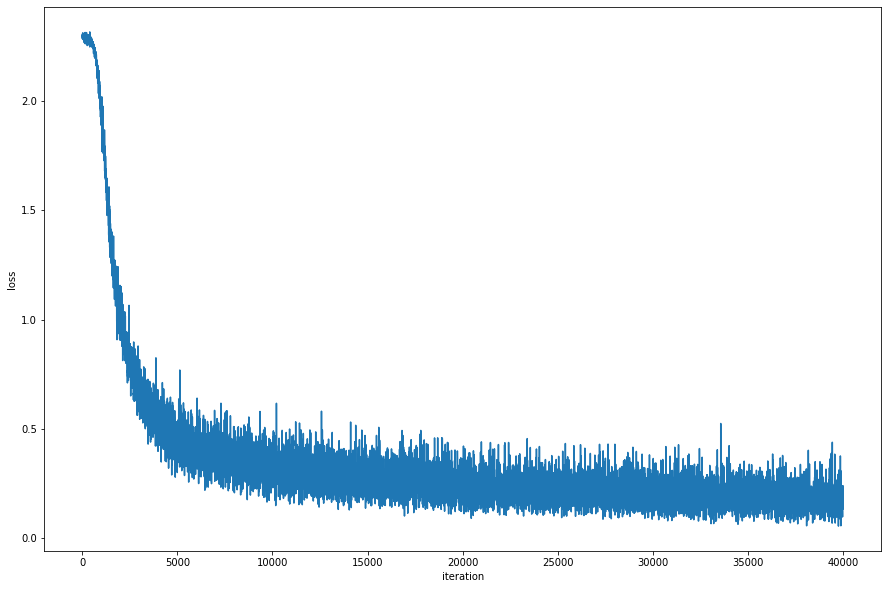

In [23]:
x = np.arange(len(train_loss_list))

plt.figure(figsize=(15, 10))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()